# Intermediate: Classifying stellar flares with *stella*

This notebook tutorial demonstrates how to determine whether or not a TESS light curve contains a stellar flare using the *stella* package. AS: I've commented out code that I may use later but doesn't strictly contribute to the current flow!

***

## Introduction

Stellar flares touch disparate corners of astrophysics. From the perspective of studying exoplanets, they may control atmospheric evolution and erosion; from the perspective of studying stars, they provide insight into stellar interiors and magnetic fields (cite a bunch)  

The TESS mission (link), with its relatively long-duration observations (28 days at a time) at a relatively short cadence (as low as 20 seconds), is well suited for searches of time-dependent stellar effects such as flares. A number of studies have used the observatory to detect flares (e.g., <a href=https://iopscience.iop.org/article/10.3847/1538-3881/abac0a/meta>Feinstein et al. 2020</a>, <a href=https://iopscience.iop.org/article/10.3847/1538-3881/ab5d3a/meta>Günther et al. 2020</a>, Adina’s paper)  

This notebook will explore stellar flare classification with neural networks. We will hew closely to the Hello Universe example [link], which makes use of the Stella code developed in [cite Adina paper].

## Import Statements

* **numpy** is used for array manipulation.
* **tarfile** is used for unpacking datasets.

* **astropy.io.fits** allows us to interact with the FITS files.
* **astropy.utils.data.download_data** is used to download the data at the location specified by a URL.
* **matplotlib.pyplot** is used to display images and plot datasets.
* **stella** is used to manipulate CNNs for classifying stellar flares.
* **keras** is used to manuipulate CNN architecture.
* **sklearn** is a machine learning library with helpful utility functions for deep learning.
* **lightkurve** allows us to easily interact with TESS light curves.

Note — importing some of these packages (such as tensorflow) can take a minute or more!

# Part 1: installation
(will fill in once I double-check that a simpler conda approach doesn't work out of the box!)

In [1]:
# arrays
import numpy as np

# unpacking files 
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

2023-06-13 04:53:36.483302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 04:53:38.159741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 04:53:38.160849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 04:54:04.136854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part 2: Science

## Downloading the *stella* data
Classification algorithms such as neural networks require large datasets to "learn" what they're looking for (we'll describe this in further detail in later sections). Luckily, the authors of the *stella* package have curated a set of TESS light curves that do and do not (as far as have been detected) exhibit flares. We'll use this dataset to help our neural network find patterns in data, via a process known as "training."

First, we identify where the file is hosted on STScI servers.

In [6]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

Next, we download and open the file. setting ``cache=True`` means that the file won't be downloaded again if it's already been downloaded before.

In [9]:
file = tarfile.open(download_file(file_url, cache=True))

Next, we extract the contents of the file, placing the folder within in the current directory — the '.' directory.

In [ ]:
file.extractall('.')
file.close() # be sure to close files when you're finished with them!

At this point, the data is downloaded and accessible to our server instance. Let's use ``stella`` to construct a ``FlareDataSet`` object with the data that we have.

In [10]:
data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 441.66it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



What is this ``ds`` object, and what did the function spit out? ``FlareDataSet``s are essentially reformatted collections of training datasets for neural networks, with the data arrays shaped for neural network inputs and labeled by whether or not they contain a flare. These labels are provided by the ``catalog``, which we specify in the ``FlareDataSet`` initialization.

The text printed to the notebook first lets us know that the files are being read in (as intended) then provides a progress bar (courtesy of the `tqdm` package). Then, we're given the statistics of the dataset: that 502 light curves contain flares, and 1342 do not. The mistmatch between lightcurves with and without flares is known as a ``class imbalance''. We'll explore in an exercise how the class imbalance impacts the neural network performance.

In [13]:
# take 2: more data
# download = stella.DownloadSets(fn_dir='.')
# download.download_catalog()
# download.flare_table = download.flare_table[0:4000]
# download.download_lightcurves()
# ds = stella.FlareDataSet(downloadSet=download)

In [14]:
# hm, check the URL.
# ds = stella.FlareDataSet(fn_dir='.',
#                          catalog='./'+'Guenther_2020_flare_catalog.txt')

In [15]:
# thought: stella does pre-conditioning. so we need to replicate that if we want to apply elsewhere.
# nope! no worries. it a;ready dies that if we do the dataset thing.

Now, let's clean up this dataset a little bit and plot it.

In [16]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

Now, let's plot a subset of the data. Let's choose random ones. Try executing the next cell a few times in a row — you'll get different plots each time!

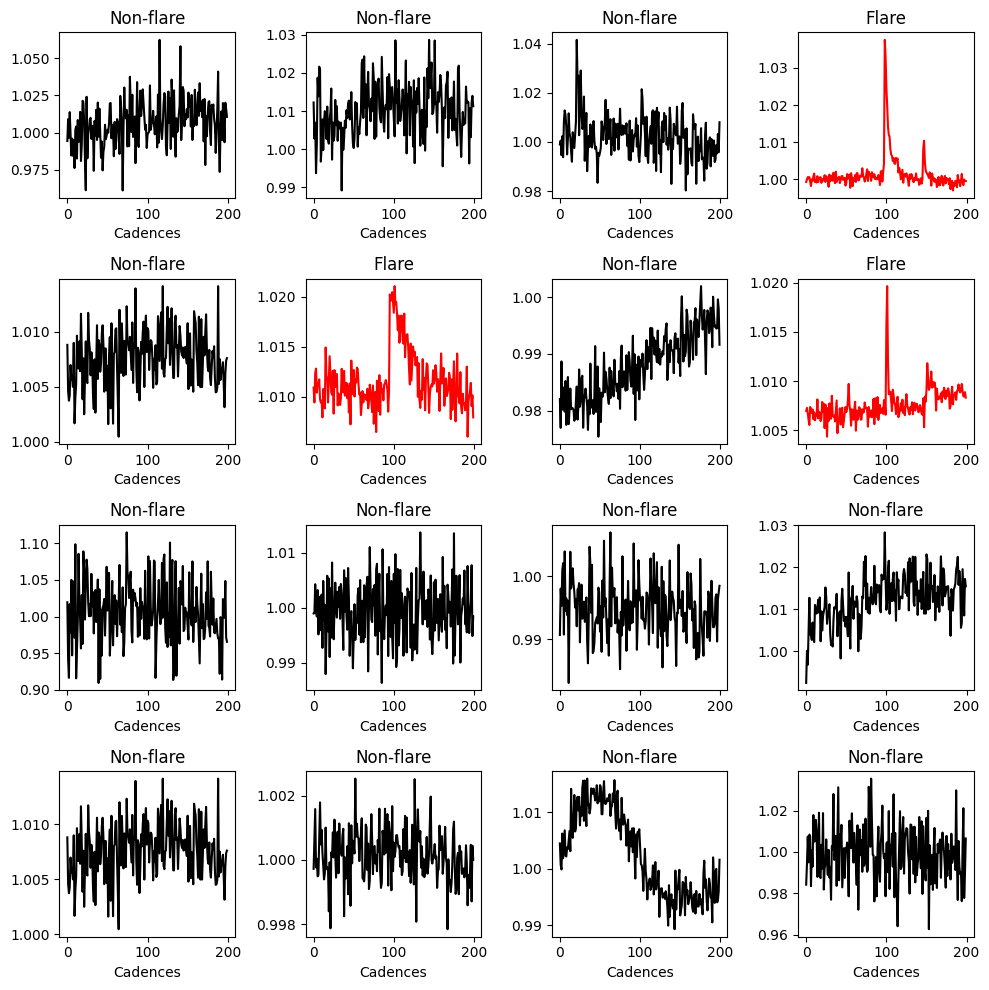

In [20]:
# select random image indices:
example_ids = np.random.choice(len(ds.train_labels), 16)

# pull the lightcurves and labels for these selections
example_lightcurves = [ds.train_data[j] for j in example_ids]
example_labels = [ds.train_labels[j] for j in example_ids]


# initialize your figure
fig = plt.figure(figsize=(10, 10))


# create two dictionaries with the same keys mapping to corresponding colors and flare property
colors = {1: 'r', 0: 'k'}
titles = {1: 'Flare', 0: 'Non-flare'}

# loop through the randomly selected images and plot with labels. The red ones indeed have flares!
for i in range(len(example_ids)):
    plt.subplot(4, 4, i + 1)
    plt.plot(example_lightcurves[i], color=colors[example_labels[i]])
    plt.title(titles[example_labels[i]])
    plt.xlabel('Cadences')
    
plt.tight_layout()
plt.show()

It seems like we have our dataset. Awesome!

## Training our neural network

### What is a classifier?

Our final goal is to take in a light curve and figure out whether it has a flare or not. We have a large labeled dataset — a list of light curves and the knowledge of whether or not they contain flares — but these examples alone will not be helpful enough to quantitatively classify a new light curve. Our eyes can sort of do the job for us, because flares have a physically motivated shape to them (AS: describe the physics)? But, ideally, we want something better than human eyes: something reproducible, something fast, something quantitative, something understandable.

Thus enters a set of algorithms known as "classifiers." These programs take in data, and spit out a "yes/no" answer. In our case, a classifier would indeed be able to tell us whether or not a lightcurve contains a flare — and perhaps even how confident the algorithm is in its answer.


### What is a neural network?

Neural networks are a specific type of of program that can be used to solve classification problems. Their namesake is the neuron in a brain, after which neural networks are loosely based. At each layer of a neural network, each neuron receives the weighted output of neurons from the previous layer. It then combines those outputs non-linearly and sends its output to the next layer. This approach allows neural networks to approximate complex and non-linear functions quite well.

But approximating functions isn't enough — we need our neural network to figure out what these functions *are*. Doing so involves training, or the act of tuning the weights between neurons mentioned above. Various algorithms (such as gradient descent) have been devised to efficiently and accurately train neural networks.


[AS: then describe CNNs here similarly. Is this the right level of depth?]


Neural nets require some weight initialization. We don't know ahead of time what the weights should be, so they're defined randomly. Setting a *random seed* for our program ensures that while it is random, it is *reproducibly* random. [AS: is this too cheeky? Should I describe more?]

In [61]:
# set the random seed
seed = 2
np.random.seed(seed)

We next want to set the filter size of our CNN — that is, how many adjacent pixels it considers.

In [62]:
filter1 = 16
filter2 = 64


Next, we should decide how many neurons to include per layer. Let's try 128 ndoes.

In [63]:
dense = 128 # was 32


After setting the number of neuraons, we set the value for our dropout layers. These layers can help prevent overfitting by killing off some weights to prevent over-complex function representations.

In [64]:
dropout = 0.1 # let's keep this low for now.


Now, we can set the neural net architecture and define our model!

In [65]:
data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

In [66]:
# something to consider: hyperparameter optimization.
# something to consider: different sections.

Next, we compile our model. We include arguments that specify how to train the network (the `optimizer`), the quantities to track during training for output (`fit_metrics`), an  how to evlauate whether the model is performing well during training (the `loss`).

In [67]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 200, 7)            119       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 100, 7)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 100, 7)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 50, 3)            0         
 1D)                                                       

That's a lot of parameters! We're starting to get a sense for why neural networks are a powerful technique.

Now, with our model all set up, we can actually train it on the dataset.

In [68]:
nb_epoch = 100
batch_size = 64
shuffle = True

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/100
23/23 [==============================] - 1s 25ms/step - loss: 0.5881 - accuracy: 0.7329 - val_loss: 0.6016 - val_accuracy: 0.7088
Epoch 2/100
23/23 [==============================] - 0s 19ms/step - loss: 0.5881 - accuracy: 0.7316 - val_loss: 0.6008 - val_accuracy: 0.7088
Epoch 3/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5793 - accuracy: 0.7336 - val_loss: 0.5945 - val_accuracy: 0.7088
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5710 - accuracy: 0.7363 - val_loss: 0.5929 - val_accuracy: 0.7143
Epoch 5/100
23/23 [==============================] - 1s 23ms/step - loss: 0.5673 - accuracy: 0.7439 - val_loss: 0.5835 - val_accuracy: 0.7143
Epoch 6/100
23/23 [==============================] - 0s 19ms/step - loss: 0.5576 - accuracy: 0.7486 - val_loss: 0.5996 - val_accuracy: 0.7143
Epoch 7/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5504 - accuracy: 0.7507 - val_loss: 0.5692 - val_accuracy: 0.7143
Epoch 

Let's save our dataset before proceeding so that we don't have to retrain the whole model if something goes wrong.

In [69]:
# save the model to file
cnn_file = 'initial_flare_model_small_dataset.h5'
cnn.save(cnn_file)
# this would be a great spot for payising and doing hyperparameter optimization. Either leaving it as exercise or exploring.

In [87]:
# put in: what's a confusion matrix?
# put in: how to *see* if things are overfitting. inspect loss!

## The confusion matrix

At each training epoch, we're told how the model's performing — its loss, its accuracy, its validation set loss, and its validation set accuracy. These numbers are great to compare against one another (especially when iterating models), but we'd like a global statistic for evaluating our models that's straightforward to understand. That's where the confusion matrix comes in.

The confusion matrix tells us: of the flares we're trying to classify, how many of the flares did we correctly identify (true positives; top left), how many did we not identify (false negatives, top right), how many non-flares did we classify as flares (false positives; bottom left), and how many non-flares did we correctly identify (true negatives; bottom right). The rows in a confusion matrix add to 100%. The best-case scenario maximizes the top left and bottom right while minimizing the top right and bottom left.

In [73]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 3ms/step


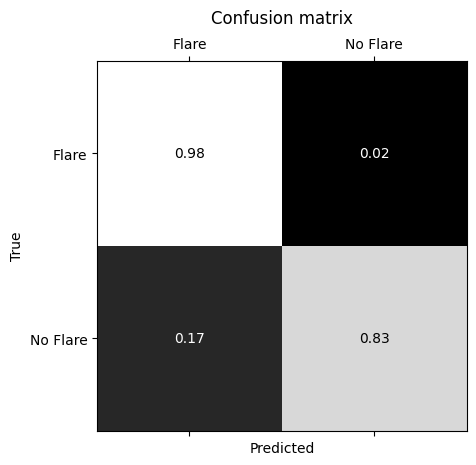

In [74]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


This looks pretty good!

## Trying the algorithm on real data
We have an algothithm that works well enough, let's apply it to real data.

In [82]:
ticids = ['120461526', '278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
# ticids = ['394015919']
# for all the selected targets, pull the available lightcurves using the lightkurve package
lcs = []
# should tqdm these
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=[1, 2], author='SPOC')
    lc = lc.download_all()
    lcs.append(lc)

In [83]:
for lc in lcs:
    if len(lc)>0: lc = lc[0] 
    if not np.all(np.isfinite(lc.flux)):
        print('bad!')

In [84]:
# load the CNN using `stella`
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

In [85]:
# huh. this all looks bad!

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


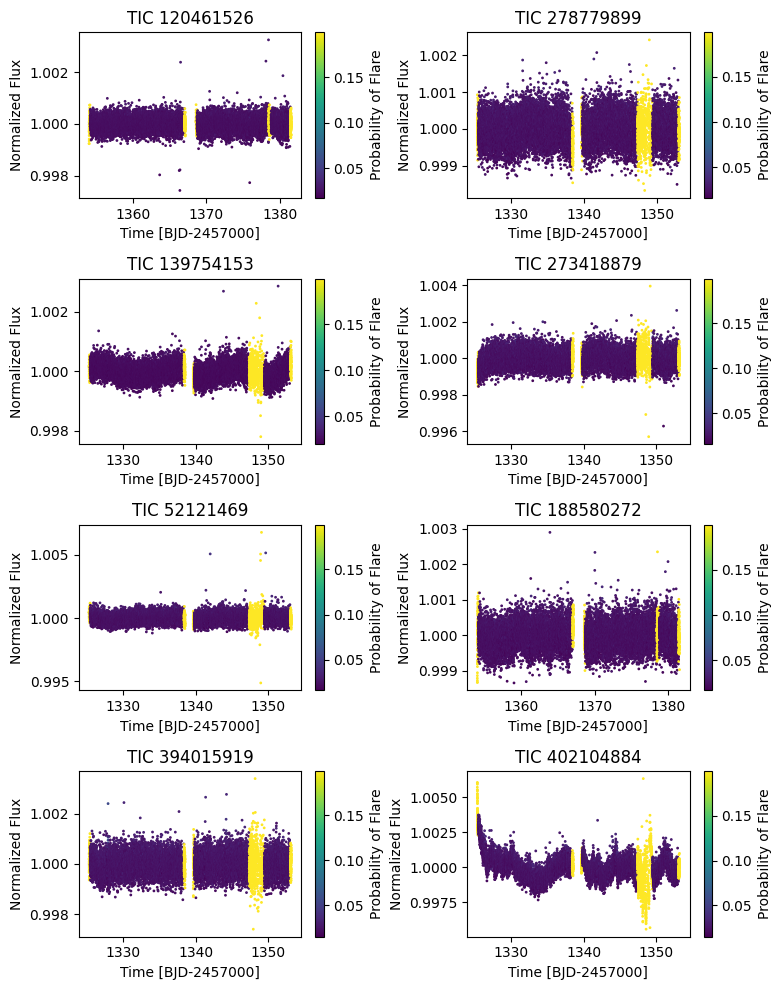

In [86]:
fig = plt.figure(0, [8, 10])

for i, lc in enumerate(lcs):
    # pull out on the first light curve in each set, if more than one exist
    if len(lc)>0: lc = lc[0]
        
    # predict the flare probability light cuvey for the input data using `stella` 
    # (which applies the necessary pre-processing to the data for input to the CNN)
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ax = fig.add_subplot(4,2,i+1)
    im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
    
    plt.colorbar(im, ax=ax, label='Probability of Flare')
    ax.set_xlabel('Time [BJD-2457000]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('TIC {}'.format(lc.targetid));
plt.tight_layout()
plt.show()

# New section (for next notebook?): fitting the flares!

In [24]:
cnn.predict(modelname=MODEL,
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)

NameError: name 'MODEL' is not defined

In [53]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])

In [54]:
ff.identify_flare_peaks(threshold=0.1)

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]WARNING: TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days [astropy.time.core]
/home/jovyan/userenv/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 18277 is out of bounds for axis 0 with size 18277

ValueError: 'c' argument has 18277 elements, which is inconsistent with 'x' and 'y' with size 18279.

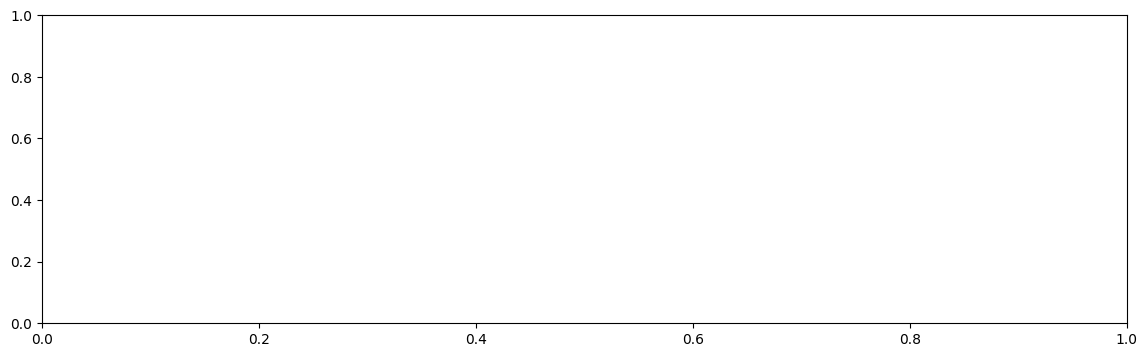

In [55]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn_stella.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)
for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)
plt.xlim(1660,1666)
plt.ylim(0.96,1.05)

In [ ]:
# and try to see some relationship between these properties.

# New section (for next notebook?): compare to rotation periods!

In [58]:
mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux], [lc.flux_err])


In [60]:
lc.time.value

array([1325.29993273, 1325.30132162, 1325.30271051, ..., 1353.17738539,
       1353.17877424, 1353.18016309])

In [59]:
mProt.run_LS()


Finding most likely periods:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: array must not contain infs or NaNs

In [ ]:
mProt.LS_results


In [ ]:
lc.fold(mProt.LS_results['avg_period_days'].data[0]).plot()


# New section (for next notebook?): apply to a bunch of different light curves!